## Importing all libraries

In [ ]:
!pip install kaggle captum torch-geometric sentence-transformers sentencepiece einops -q

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import google.generativeai as genai
from IPython.display import display, Markdown
import torch
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
import warnings
warnings.filterwarnings('ignore')

data = {
    "username": "elucidator8918",
    "key": "790d5a40d3214c4871f03cf7f499d277"
}

with open('kaggle.json', 'w') as json_file:
    json.dump(data, json_file)

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rocki37/open-university-learning-analytics-dataset
!kaggle datasets download -d anthonysusevski/course-reviews-university-of-waterloo
!kaggle datasets download -d elucidator8918/course-data-area-of-interest
!unzip course-data-area-of-interest.zip
!unzip course-reviews-university-of-waterloo
!unzip open-university-learning-analytics-dataset.zip
!rm open-university-learning-analytics-dataset.zip course-reviews-university-of-waterloo.zip course-data-area-of-interest.zip
!rm -rf anonymiseddata
!rm assessments.csv studentAssessment.csv studentRegistration.csv studentVle.csv vle.csv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
courses = pd.read_csv("courses.csv")

alltuples = list(zip(courses['code_module'],courses['code_presentation']))
replacelist = [
    ('AAA', '2013J'),
    ('AAA', '2014J'),
    ('BBB', '2013J'),
    ('BBB', '2014J'),
    ('DDD', '2014J'),
    ('EEE', '2013J'),
    ('EEE', '2014J'),
    ('EEE', '2014B'),
    ('GGG', '2013J'),
    ('GGG', '2014B'),
    ('GGG', '2014J'),
    ('FFF', '2013J'),
    ('FFF', '2013B')
]
removelist = list(set(alltuples)-set(replacelist))

## Course - Data Engineer

In [ ]:
coursesext = pd.read_csv("course_data_clean.csv").dropna().reset_index(drop=True)
coursesext = coursesext.drop(columns=["course_rating","course_rating_int"])
coursecodes = list(coursesext.course_code.value_counts().head(13).to_dict().keys())

In [ ]:
def corpusmake(df, coursecodes):
  final_df = pd.DataFrame(columns=df.columns)
  for course_code in coursecodes:
      selected_row = df.loc[df['course_code'] == course_code].head(1).copy()
      reviews_concatenated = '\n'.join(df.loc[df['course_code'] == course_code, 'reviews'])
      selected_row.at[selected_row.index[0], 'reviews'] = reviews_concatenated
      final_df = pd.concat([final_df, selected_row], ignore_index=True)
  return final_df

In [ ]:
courses_nodes = corpusmake(coursesext,coursecodes)
courses_nodes.to_csv('course_data_clean_transformed.csv', index=False)
courses_nodes

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews
0,MATH 135,Algebra for Honours Mathematics,1186,84%,41%,78%,253,Welcome to Waterloo Math.\npretty useful for t...
1,ECON 101,Introduction to Microeconomics,1143,64%,70%,45%,214,"Took it online in W21 during COVID, concepts w..."
2,MATH 137,Calculus 1 for Honours Mathematics,780,86%,56%,69%,171,"and then isaac newton said ""it's calculating t..."
3,CS 135,Designing Functional Programs,687,90%,69%,89%,146,"racket, the language for this course is kinda ..."
4,MATH 115,Linear Algebra for Engineering,712,83%,42%,67%,136,you really have to do assignments and practice...
5,MATH 136,Linear Algebra 1 for Honours Mathematics,671,79%,41%,59%,132,"Interesting course, just don't take it with Fr..."
6,ENGL 109,Introduction to Academic Writing,540,42%,76%,42%,135,i hate writing and this god forsaken language ...
7,STAT 230,Probability,642,84%,58%,61%,131,The course is not hard at all as long as you k...
8,CHE 102,Chemistry for Engineers,760,23%,71%,34%,130,"I don't really like chemistry in general, but ..."
9,PD 1,Career Fundamentals,664,21%,81%,6%,127,"Easy course, lots of work to do at the beginni..."


In [ ]:
prereq_data = {
    'course_code': ['CS 136', 'MATH 137', 'MATH 239', 'MATH 136', 'STAT 230'],
    'prerequisite': ['CS 135', 'MATH 135', 'MATH 135', 'MATH 115', 'MATH 239']
}

prereq_df = pd.DataFrame(prereq_data)
prereq_df.to_csv("prereq.csv",index=False)

## Student - Data Engineer

In [ ]:
band_mapping = {
    '90-100%': "Experiencing extremely low levels of multiple deprivation.",
    '80-90%': "Encountering very low levels of multiple deprivation.",
    '70-80%': "Facing low to moderate levels of multiple deprivation.",
    '60-70%': "Navigating through moderate levels of multiple deprivation.",
    '50-60%': "Dealing with moderate to high levels of multiple deprivation.",
    '40-50%': "Confronting high to moderate levels of multiple deprivation.",
    '30-40%': "Coping with high levels of multiple deprivation.",
    '20-30%': "Encountering very high levels of multiple deprivation.",
    '10-20%': "Facing very high levels of multiple deprivation.",
    '0-10%': "Confronting extremely high levels of multiple deprivation.",
}

In [ ]:
studinfo = pd.read_csv("studentInfo.csv")
aoi = pd.read_csv("generated.csv").drop_duplicates().reset_index(drop=True)

studinfo = studinfo.drop(columns=["gender","age_band","num_of_prev_attempts"]).dropna().reset_index(drop=True)
for k, (i, j) in enumerate(replacelist):
    condition = (studinfo['code_module'] == i) & (studinfo['code_presentation'] == j)
    studinfo.loc[condition, 'code_module'] = coursecodes[k]
for k, (i, j) in enumerate(removelist):
    condition = (studinfo['code_module'] == i) & (studinfo['code_presentation'] == j)
    studinfo = studinfo.loc[~condition]

studinfo = studinfo.rename(columns={"code_module":"course_code"})
studinfo['imd_band'] = studinfo['imd_band'].replace(band_mapping)
studinfo['disability'] = studinfo['disability'].map({'Y': 1, 'N': 0})
studinfo['final_result'] = studinfo['final_result'].map({'Fail': -1, 'Withdrawn': 0,"Pass":1,"Distinction":2})
studinfo['studied_credits'] = (studinfo['studied_credits'] - studinfo['studied_credits'].min()) / (studinfo['studied_credits'].max() - studinfo['studied_credits'].min())
studinfo['region_imd_band'] = studinfo['region'] + '|' + studinfo['imd_band']
studinfo = studinfo.drop(columns=["region","imd_band","code_presentation"]).sample(9496).reset_index(drop=True)
studinfo = pd.concat([studinfo, aoi.rename(columns={"Generated_Content": "Area_of_Interest"})], axis=1)
studinfo.to_csv('studentInfo_transformed.csv', index=False)

studinfo

,course_code,id_student,highest_education,studied_credits,disability,final_result,region_imd_band,Area_of_Interest
0,MATH 115,656164,Lower Than A Level,0.048,1,-1,East Midlands Region|Navigating through modera...,Learning quantum mechanics has ignited my curi...
1,CS 136,529871,A Level or Equivalent,0.192,0,1,East Anglian Region|Confronting high to modera...,Debating the latest geopolitical events with m...
2,MATH 135,2523736,A Level or Equivalent,0.144,0,1,North Western Region|Encountering very high le...,Attending hackathons fosters my passion for pr...
3,CHE 102,565640,Lower Than A Level,0.000,0,1,South Region|Navigating through moderate level...,Delving into literature's classics broadens my...
4,CS 136,550763,A Level or Equivalent,0.048,0,2,East Anglian Region|Dealing with moderate to h...,Engaging in student government allows me to co...
...,...,...,...,...,...,...,...,...
9491,CHE 102,602026,Lower Than A Level,0.000,0,-1,London Region|Confronting extremely high level...,"The allure of the stage captivates me, leading..."
9492,SPCOM 223,688379,Lower Than A Level,0.000,0,1,Scotland|Navigating through moderate levels of...,"I am intrigued by the world of fashion design,..."
9493,STAT 230,621401,A Level or Equivalent,0.048,0,-1,Yorkshire Region|Coping with high levels of mu...,I am fascinated by the complexities of interna...
9494,MATH 137,598865,Lower Than A Level,0.048,0,1,South Region|Dealing with moderate to high lev...,The study of literature allows me to analyze a...


## Graph Construction

In [ ]:
class SequenceEncoder(object):
  def __init__(self,model_name='all-MiniLM-L6-v2',device=None):
    self.device = device
    self.model = SentenceTransformer(model_name,device=device)

  @torch.no_grad()
  def __call__(self,df):
    return self.model.encode(df.values,show_progress_bar=True,convert_to_tensor=True,device=self.device).cpu()

class IdentityEncoder(object):
  def __init__(self,dtype=None):
    self.dtype = dtype

  def __call__(self,df):
    return torch.from_numpy(df.values).view(-1,1).to(self.dtype)

In [ ]:
def load_node_csv(path,index_col,encoders=None,**kwargs):
  df = pd.read_csv(path,index_col=index_col)
  mapping = {index:i for i,index in enumerate(df.index.unique())}
  x=None
  if encoders is not None:
    x = torch.cat([encoder(df[col]) for col,encoder in encoders.items()] ,dim=-1)
  return x,mapping

def load_edge_csv(path,src,srcmap,dst,dstmap,encoders=None,**kwargs):
  df = pd.read_csv(path)
  src = [srcmap[index] for index in df[src]]
  dst = [dstmap[index] for index in df[dst]]
  edge_index = torch.tensor([src,dst])
  edge_attr = None
  if encoders is not None:
      edge_attr = torch.cat([encoder(df[col]) for col,encoder in encoders.items()] ,dim=-1)
  return edge_index,edge_attr

In [ ]:
course_x,course_map = load_node_csv("course_data_clean_transformed.csv",'course_code',encoders={'course_title':SequenceEncoder(),'reviews':SequenceEncoder()})
user_x,user_map = load_node_csv("studentInfo_transformed.csv",'id_student',encoders={'region_imd_band':SequenceEncoder(),'highest_education':SequenceEncoder()})

edge_index,edge_label = load_edge_csv("studentInfo_transformed.csv",'id_student',user_map,'course_code',course_map,encoders={'final_result':IdentityEncoder(dtype=torch.long)})
prereq_edge_index,_ = load_edge_csv("prereq.csv",'prerequisite',course_map,'course_code',course_map)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/297 [00:00<?, ?it/s]

Batches:   0%|          | 0/297 [00:00<?, ?it/s]

In [ ]:
course_x.shape # Encoded titles

torch.Size([13, 768])

In [ ]:
course_map # mapping of the courses

{'MATH 135': 0,
 'ECON 101': 1,
 'MATH 137': 2,
 'CS 135': 3,
 'MATH 115': 4,
 'MATH 136': 5,
 'ENGL 109': 6,
 'STAT 230': 7,
 'CHE 102': 8,
 'PD 1': 9,
 'SPCOM 223': 10,
 'MATH 239': 11,
 'CS 136': 12}

In [ ]:
user_x.shape

torch.Size([9496, 768])

In [ ]:
len(user_map)

9399

In [ ]:
data = HeteroData()

data['student'].x = user_x
data['course'].x = course_x

data['student','results','course'].edge_index = edge_index
data['student','results','course'].edge_label = edge_label

print(data)

HeteroData(
  student={ x=[9496, 768] },
  course={ x=[13, 768] },
  (student, results, course)={
    edge_index=[2, 9496],
    edge_label=[9496, 1],
  }
)


In [ ]:
data = ToUndirected()(data)
del data['course','rev_results','student'].edge_label
data['course','prerequisite','course'].edge_index = prereq_edge_index

## Graph Visualization

In [ ]:
from bokeh.io import show
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, PanTool, TapTool, BoxSelectTool, LabelSet, ColumnDataSource, WheelZoomTool, ResetTool
from bokeh.plotting import figure, from_networkx, show
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap
import networkx as nx
import bokeh.io
bokeh.io.output_notebook()

G = nx.DiGraph()

for node_type in data.node_types:
    num_nodes = data[node_type].num_nodes
    G.add_nodes_from(range(num_nodes), label=node_type)

for edge_type in data.edge_types:
    if data[edge_type] == {}:
        continue
    edge_index_data = data[edge_type].edge_index
    for i in range(edge_index_data.size(1)):
        source_node = edge_index_data[0, i].item()
        target_node = edge_index_data[1, i].item()
        G.add_edge(source_node, target_node, label=edge_type)


plot = Plot(width=1200, height=1000,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Colorful Graph Visualization with Bokeh"

hover = HoverTool()
hover.tooltips = [("Node", "@index"), ("Label", "@label")]
plot.add_tools(hover, PanTool(),TapTool(), BoxSelectTool(), WheelZoomTool(), ResetTool())

graph_renderer = from_networkx(G, nx.spring_layout, scale=1, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=linear_cmap('index', Viridis256, 0, max(G.nodes)))
graph_renderer.edge_renderer.glyph = MultiLine(line_color="gray", line_alpha=0.8, line_width=1)

node_labels = nx.get_node_attributes(G, 'label')
node_source = ColumnDataSource(data=dict(index=[], label=[]))
for node, label in node_labels.items():
    node_source.data['index'].append(node)
    node_source.data['label'].append(label)
graph_renderer.node_renderer.data_source = node_source
plot.renderers.append(graph_renderer)
show(plot)

## Graph Neural Network Architecture

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
import math
import os
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero

device = 'cuda' if torch.cuda.is_available() else 'cpu'
transforms = RandomLinkSplit(num_val=0.05,num_test=0.1,neg_sampling_ratio=0.0,
                             edge_types=[('student','results','course')],
                             rev_edge_types=[('course','rev_results','student')])

train_data,val_data,test_data = transforms(data)
print(train_data)
print(val_data)
print(test_data)
data.to(device)
train_data.to(device)
val_data.to(device)
test_data.to(device)

HeteroData(
  student={ x=[9496, 768] },
  course={ x=[13, 768] },
  (student, results, course)={
    edge_index=[2, 8073],
    edge_label=[8073, 1],
    edge_label_index=[2, 8073],
  },
  (course, rev_results, student)={ edge_index=[2, 8073] },
  (course, prerequisite, course)={ edge_index=[2, 5] }
)
HeteroData(
  student={ x=[9496, 768] },
  course={ x=[13, 768] },
  (student, results, course)={
    edge_index=[2, 8073],
    edge_label=[474, 1],
    edge_label_index=[2, 474],
  },
  (course, rev_results, student)={ edge_index=[2, 8073] },
  (course, prerequisite, course)={ edge_index=[2, 5] }
)
HeteroData(
  student={ x=[9496, 768] },
  course={ x=[13, 768] },
  (student, results, course)={
    edge_index=[2, 8547],
    edge_label=[949, 1],
    edge_label_index=[2, 949],
  },
  (course, rev_results, student)={ edge_index=[2, 8547] },
  (course, prerequisite, course)={ edge_index=[2, 5] }
)


HeteroData(
  student={ x=[9496, 768] },
  course={ x=[13, 768] },
  (student, results, course)={
    edge_index=[2, 8547],
    edge_label=[949, 1],
    edge_label_index=[2, 949],
  },
  (course, rev_results, student)={ edge_index=[2, 8547] },
  (course, prerequisite, course)={ edge_index=[2, 5] }
)

Epoch: 001, Train RMSE: 1.3348, Val RMSE: 1.3117, Test RMSE: 1.3096, LR: 0.0100000000
Epoch: 002, Train RMSE: 1.0798, Val RMSE: 1.0868, Test RMSE: 1.1015, LR: 0.0100000000
Epoch: 003, Train RMSE: 0.9953, Val RMSE: 0.9981, Test RMSE: 1.0118, LR: 0.0100000000
Epoch: 004, Train RMSE: 0.9371, Val RMSE: 0.9330, Test RMSE: 0.9443, LR: 0.0100000000
Epoch: 005, Train RMSE: 0.9686, Val RMSE: 0.9557, Test RMSE: 0.9623, LR: 0.0100000000
Epoch: 006, Train RMSE: 0.9485, Val RMSE: 0.9374, Test RMSE: 0.9452, LR: 0.0100000000
Epoch: 007, Train RMSE: 0.9332, Val RMSE: 0.9286, Test RMSE: 0.9397, LR: 0.0100000000
Epoch: 008, Train RMSE: 0.9438, Val RMSE: 0.9416, Test RMSE: 0.9537, LR: 0.0100000000
Epoch: 009, Train RMSE: 0.9392, Val RMSE: 0.9362, Test RMSE: 0.9480, LR: 0.0100000000
Epoch: 010, Train RMSE: 0.9287, Val RMSE: 0.9226, Test RMSE: 0.9330, LR: 0.0100000000
Epoch: 011, Train RMSE: 0.9344, Val RMSE: 0.9246, Test RMSE: 0.9333, LR: 0.0100000000
Epoch: 012, Train RMSE: 0.9339, Val RMSE: 0.9242, Test

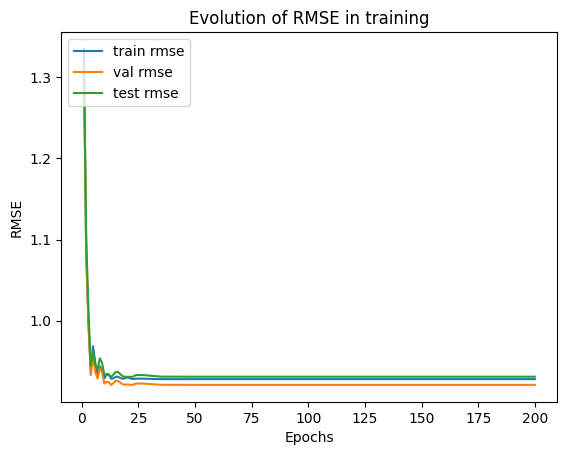

In [ ]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['student'][row], z_dict['course'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

model = Model(hidden_channels=64).to(device)

# Due to lazy initialization, we need to run one model step so the number of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['student','results' ,'course'].edge_index)
    target = train_data['student','results' ,'course'].edge_label.float()
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(testing_data,val=False):
    model.eval()
    pred = model(testing_data.x_dict, testing_data.edge_index_dict,
                 testing_data['student','results','course'].edge_index)
    pred = pred.clamp(min=-1, max=2)
    target = testing_data['student','results','course'].edge_label.float()
    loss = F.mse_loss(pred, target)
    if val:
        scheduler.step(loss)
    rmse = loss.sqrt()
    return float(rmse)

train_rmse_list = []
val_rmse_list = []
test_rsme_list = []
EPOCHS = 200
os.mkdir("models")
BEST_MODEL_PATH = "models/best-sageconv.pt"
MODEL_PATH = 'models/sageconv.pt'

best_loss = math.inf

def main():
    for epoch in range(1, EPOCHS+1):
        loss = train()
        if loss < best_loss:
            torch.save({'state_dict':model.state_dict(),
                        'user_map':user_map,
                        'course_map':course_map,
                        'data':data,
                        'courses':courses_nodes}, BEST_MODEL_PATH)

        train_rmse = test(train_data)
        train_rmse_list.append(train_rmse)
        val_rmse = test(val_data, val=True)
        val_rmse_list.append(val_rmse)
        test_rmse = test(test_data)
        test_rsme_list.append(test_rmse)
        lr = optimizer.state_dict()['param_groups'][0]['lr']
        print(f'Epoch: {epoch:03d}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}, LR: {lr:.10f}')

    torch.save({'state_dict':model.state_dict(),
                'user_map':user_map,
                'course_map':course_map,
                'data':data,
                'courses':courses_nodes}, MODEL_PATH)

    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.title("Evolution of RMSE in training")
    plt.plot(range(1,EPOCHS+1), train_rmse_list, label="train rmse")
    plt.plot(range(1,EPOCHS+1), val_rmse_list, label="val rmse")
    plt.plot(range(1,EPOCHS+1), test_rsme_list, label="test rmse")
    plt.legend(loc="upper left")
    plt.show()

if __name__=="__main__":
    main()

In [ ]:
model = Model(hidden_channels=64).to(device)
model.load_state_dict(torch.load(MODEL_PATH)['state_dict'])
model.eval()

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (student__results__course): SAGEConv((-1, -1), 64, aggr=mean)
      (course__rev_results__student): SAGEConv((-1, -1), 64, aggr=mean)
      (course__prerequisite__course): SAGEConv((-1, -1), 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (student__results__course): SAGEConv((-1, -1), 64, aggr=mean)
      (course__rev_results__student): SAGEConv((-1, -1), 64, aggr=mean)
      (course__prerequisite__course): SAGEConv((-1, -1), 64, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=128, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
t = studinfo.sample(1).reset_index(drop=True)
student_id = t['id_student'][0]
current_course_code = t['course_code'][0]
t

,course_code,id_student,highest_education,studied_credits,disability,final_result,region_imd_band,Area_of_Interest
0,CS 135,254313,HE Qualification,0.336,1,0,South East Region|Encountering very high level...,"I'm an active member of a robotics club, build..."


In [ ]:
num_courses = 5
already_seen = course_map[current_course_code]
real_user = user_map[student_id]
len_movies = len(data['course'].x)
row = torch.tensor([real_user] * len_movies).to(device)
col = torch.arange(len_movies).to(device)
edge_label_index = torch.stack([row, col], dim=0).to(device)
pred = model(data.x_dict, data.edge_index_dict, edge_label_index)
pred = pred.clamp(min=-1, max=2)
pred[already_seen] = 0
idx_max = torch.topk(pred, num_courses).indices
string = f"Course Taken By the Student: {current_course_code}\n"
string += 'Recommended courses for Student Id: ' + str(student_id)+"\n"
for k,i in enumerate(idx_max):
    string+=f"{k+1}. "+courses_nodes.loc[int(i)]["course_title"]+"\n"
string=string[:-1]
print(string)

Course Taken By the Student: CS 135
Recommended courses for Student Id: 254313
1. Probability
2. Introduction to Academic Writing
3. Calculus 1 for Honours Mathematics
4. Elementary Algorithm Design and Data Abstraction
5. Career Fundamentals


In [ ]:
real_user

825

## Explainability Model

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.explain.algorithm import CaptumExplainer

explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer("Saliency"),
    explanation_type="model",
    model_config=dict(
        mode="binary_classification",
        task_level="edge",
        return_type="probs",
    ),
    node_mask_type="attributes",
    edge_mask_type="object",
    threshold_config=dict(
        threshold_type="topk",
        value=1
    )
)

In [ ]:
index = torch.tensor(list(range(1764,1777)))  # Explain edge labels with index 2 and 10.
explanation = explainer(
    data.x_dict,
    data.edge_index_dict,
    index=index,
    edge_label_index=data["student", "results", "course"].edge_index,

)
print(f"Generated explanations in {explanation.available_explanations}")

path = "feature_importance.png"
explanation.visualize_feature_importance(path, top_k=5)
print(f"Feature importance plot has been saved to '{path}'")

Generated explanations in ['edge_mask', 'node_mask']
Feature importance plot has been saved to 'feature_importance.png'
